<a href="https://colab.research.google.com/github/31shivam/ALY6110/blob/Google-Collab/Group%20Assignment%20M4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [5]:
# Download Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz


In [6]:
# Unzip the file
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.1-bin-hadoop3'

In [8]:
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [9]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [10]:
# Import a Spark function from library
from pyspark.sql.functions import col

In [11]:
print(spark.sparkContext)
print("Spark App Name : "+ spark.sparkContext.appName)

<SparkContext master=local[*] appName=pyspark-shell>
Spark App Name : pyspark-shell


In [12]:
df=spark.sql("show databases")
df.show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [13]:
from google.colab import files
files.upload()

Saving car_prices.csv to car_prices.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error

from sklearn.ensemble import RandomForestRegressor

In [17]:
df = pd.read_csv('car_prices.csv', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 408163: expected 16 fields, saw 17\nSkipping line 417837: expected 16 fields, saw 17\nSkipping line 421291: expected 16 fields, saw 17\nSkipping line 424163: expected 16 fields, saw 17\n'
b'Skipping line 427042: expected 16 fields, saw 17\nSkipping line 427045: expected 16 fields, saw 17\nSkipping line 434426: expected 16 fields, saw 17\nSkipping line 444503: expected 16 fields, saw 17\nSkipping line 453796: expected 16 fields, saw 17\n'
b'Skipping line 461599: expected 16 fields, saw 17\nSkipping line 461614: expected 16 fields, saw 17\n'
b'Skipping line 492486: expected 16 fields, saw 17\nSkipping line 497010: expected 16 fields, saw 17\nSkipping line 497013: expected 16 fields, saw 17\nSkipping line 499085: expected 16 fields, saw 17\

In [18]:
#read data and select year between 2010-2015
df.head()
df1 = df[(df["year"] >= 2010) & (df["year"] <= 2015)]
#select columns
df1 = pd.DataFrame(df1,columns = ["condition","odometer","mmr","sellingprice"])
df1.head()

,condition,odometer,mmr,sellingprice
0,5.0,16639.0,20500,21500
1,5.0,9393.0,20800,21500
2,4.5,1331.0,31900,30000
3,4.1,14282.0,27500,27750
4,4.3,2641.0,66000,67000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


In [20]:
#show NA
df1.isnull().sum()
print(df1.isnull().sum())

condition       2184
odometer          12
mmr                0
sellingprice       0
dtype: int64


In [21]:
# fill NA value with mode
df1 = df1.fillna(value={"condition":df1["condition"].mode()[0],"odometer":df1["odometer"].mode()[0]})
#show NA
df1.isnull().sum()
print(df1.isnull().sum())
#chech data types
print(df1.dtypes)

condition       0
odometer        0
mmr             0
sellingprice    0
dtype: int64
condition       float64
odometer        float64
mmr               int64
sellingprice      int64
dtype: object


In [22]:
#change data types
df1["mmr"]= df1["mmr"].astype(float)
df1["sellingprice"]= df1["sellingprice"].astype(float)
df1.dtypes

condition       float64
odometer        float64
mmr             float64
sellingprice    float64
dtype: object

In [23]:
#def function to remove outliers
def outliners(data,col,scale=3):
    def box_plot_outliners(data_ser,box_scale):
        IQR=box_scale*(data_ser.quantile(0.75)-data_ser.quantile(0.25))
        val_low=data_ser.quantile(0.25)-IQR
        val_up=data_ser.quantile(0.75)+IQR
        rule_low=(data_ser<val_low)
        rule_up=(data_ser>val_up)
        return rule_low,rule_up,val_low,val_up
    data_n=data.copy()
    data_series=data_n[col]
    rule_low,rule_up,val_low,val_up=box_plot_outliners(data_series,box_scale=scale)
    data_n[col].loc[rule_up]=val_up
    data_n[col].loc[rule_low]=val_low
    return data_n

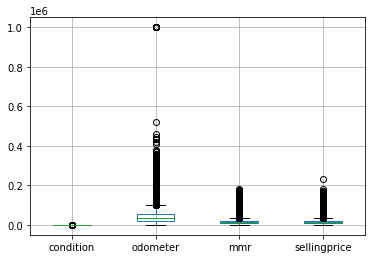

In [24]:
#show outliers
df1.boxplot()
plt.show()

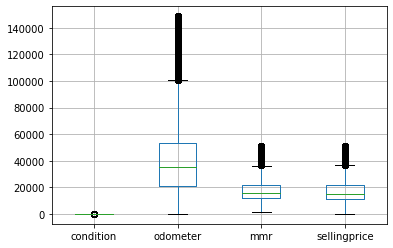

In [ ]:
#remove outliers
df1 = outliners(df1,"condition",scale=3)
df1 = outliners(df1,"odometer",scale=3)
df1 = outliners(df1,"mmr",scale=3)
df1 = outliners(df1,"sellingprice",scale=3)

#boxplot
df1.boxplot()
plt.show()

In [ ]:
#show correlation
df1.corr()

,condition,odometer,mmr,sellingprice
condition,1.000000,-0.316723,0.279409,0.358181
odometer,-0.316723,1.000000,-0.364733,-0.363060
mmr,0.279409,-0.364733,1.000000,0.977864
sellingprice,0.358181,-0.363060,0.977864,1.000000


C:\Users\parth\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\parth\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


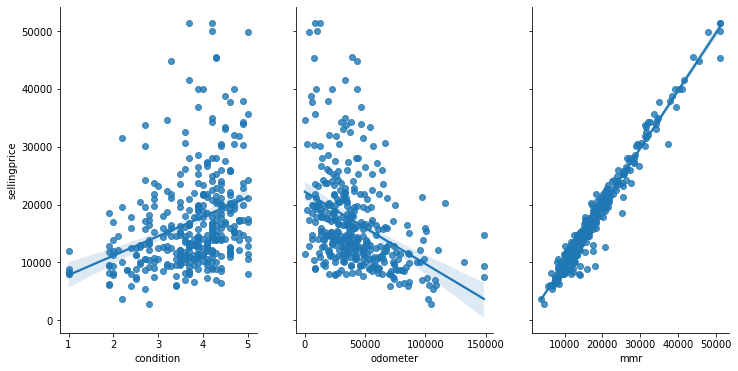

In [ ]:
#Select the right proportion of data to create the visualization
more_data,less_data = train_test_split(df1,train_size=.999)
#Build a scatter chart to see the distribution of data
ax = sns.pairplot(less_data, x_vars=['condition','odometer','mmr'], y_vars='sellingprice',aspect=0.1,kind = 'reg')
ax.figure.set_size_inches(12,6)

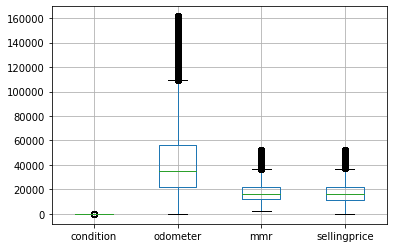

In [ ]:
#def function to remove outliers
def outliners(data,col,scale=3):
    def box_plot_outliners(data_ser,box_scale):
        IQR=box_scale*(data_ser.quantile(0.75)-data_ser.quantile(0.25))
        val_low=data_ser.quantile(0.25)-IQR
        val_up=data_ser.quantile(0.75)+IQR
        rule_low=(data_ser<val_low)
        rule_up=(data_ser>val_up)
        return rule_low,rule_up,val_low,val_up
    data_n=data.copy()
    data_series=data_n[col]
    rule_low,rule_up,val_low,val_up=box_plot_outliners(data_series,box_scale=scale)
    data_n[col].loc[rule_up]=val_up
    data_n[col].loc[rule_low]=val_low
    return data_n
#remove outliers
df_Ford = outliners(df_Ford,"condition",scale=3)
df_Ford = outliners(df_Ford,"odometer",scale=3)
df_Ford = outliners(df_Ford,"mmr",scale=3)
df_Ford = outliners(df_Ford,"sellingprice",scale=3)

df_Nissan = outliners(df_Nissan,"condition",scale=3)
df_Nissan = outliners(df_Nissan,"odometer",scale=3)
df_Nissan = outliners(df_Nissan,"mmr",scale=3)
df_Nissan = outliners(df_Nissan,"sellingprice",scale=3)

#boxplot
df_Ford.boxplot()
plt.show()

In [ ]:
df1 = df1.drop(["vin","saledate"],axis=1)

In [ ]:
#show NA
df1.isnull().sum()
print(df1.isnull().sum())

year                0
make             2530
model            2628
trim             2564
body             3027
transmission    44969
state               0
condition        2184
odometer           12
color             594
interior          594
seller              0
mmr                 0
sellingprice        0
dtype: int64


In [ ]:
df1.isnull().mean().mul(100).sort_values(ascending=False)

transmission    12.286713
body             0.827056
model            0.718039
trim             0.700552
make             0.691262
condition        0.596726
color            0.162296
interior         0.162296
odometer         0.003279
year             0.000000
state            0.000000
seller           0.000000
mmr              0.000000
sellingprice     0.000000
dtype: float64

In [ ]:
df1.describe()

,year,condition,odometer,mmr,sellingprice
count,365997.000000,363813.000000,365985.000000,365997.000000,365997.000000
mean,2012.510996,3.761172,40491.471405,17653.509113,17461.506092
std,1.243643,0.818880,28171.896845,9169.108739,9266.244170
min,2010.000000,1.000000,1.000000,1100.000000,1.000000
25%,2012.000000,3.300000,21275.000000,11600.000000,11400.000000
50%,2013.000000,3.900000,34904.000000,15400.000000,15200.000000
75%,2013.000000,4.400000,53106.000000,21500.000000,21400.000000
max,2015.000000,5.000000,999999.000000,182000.000000,230000.000000


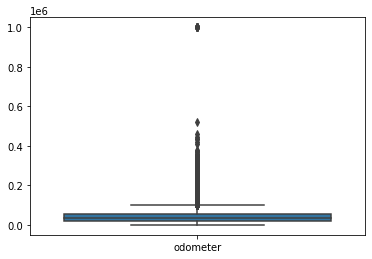

In [ ]:
ax = sns.boxplot(data=df1[["odometer"]])


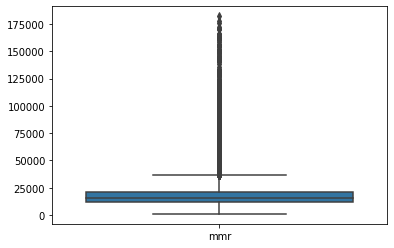

In [ ]:
ax = sns.boxplot(data=df1[["mmr"]])

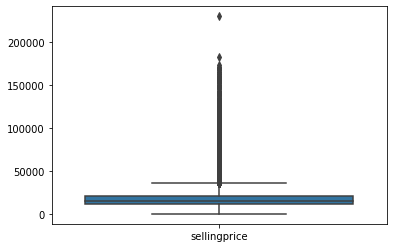

In [ ]:
ax = sns.boxplot(data=df1[["sellingprice"]])

In [ ]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

df1 = df1[~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))).any(axis=1)]

C:\Users\parth\AppData\Local\Temp/ipykernel_14104/775481838.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df1 = df1[~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))).any(axis=1)]


In [ ]:
df1

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000
7,2014,Chevrolet,Cruze,1LT,Sedan,automatic,ca,2.0,28617.0,black,black,enterprise vehicle exchange / tra / rental / t...,11900,9800
8,2014,Audi,A4,2.0T Premium Plus quattro,Sedan,automatic,ca,4.2,9557.0,white,black,audi mission viejo,32100,32250
9,2014,Chevrolet,Camaro,LT,Convertible,automatic,ca,3.0,4809.0,red,black,d/m auto sales inc,26300,17500
14,2014,Chevrolet,Cruze,2LT,Sedan,automatic,ca,NaN,15686.0,blue,black,avis rac/san leandro,13900,10600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558804,2012,Nissan,Sentra,2.0 SR,Sedan,NaN,tn,2.6,35858.0,white,gray,nissan-infiniti lt,9950,10400
558805,2011,BMW,5 Series,528i,Sedan,automatic,fl,3.9,66403.0,white,brown,lauderdale imports ltd bmw pembrok pines,20300,22800
558807,2012,Ram,2500,Power Wagon,Crew Cab,automatic,wa,5.0,54393.0,white,black,i -5 uhlmann rv,30200,30800
558808,2012,BMW,X5,xDrive35d,SUV,automatic,ca,4.8,50561.0,black,black,financial services remarketing (lease),29800,34000


In [ ]:
df1.isnull().mean().mul(100).sort_values(ascending=False)

transmission    12.239310
body             0.559665
condition        0.505808
trim             0.467523
make             0.463954
model            0.463954
color            0.134320
interior         0.134320
odometer         0.002271
year             0.000000
state            0.000000
seller           0.000000
mmr              0.000000
sellingprice     0.000000
dtype: float64

In [ ]:
df1.describe(include="object")

,make,model,trim,body,transmission,state,color,interior,seller
count,306790,306790,306779,306495,270496,308220,307806,307806,308220
unique,52,407,677,67,2,38,20,17,7304
top,Ford,Altima,SE,Sedan,automatic,fl,black,black,nissan-infiniti lt
freq,61426,16151,33708,122224,264101,47654,63112,166013,19595


In [ ]:
df1.describe()

,year,condition,odometer,mmr,sellingprice
count,308220.000000,306661.000000,308213.000000,308220.000000,308220.000000
mean,2012.649750,3.797368,36624.976386,16797.670495,16654.535621
std,0.996308,0.767345,20032.491040,6408.217226,6511.911353
min,2011.000000,1.700000,1.000000,2650.000000,1.000000
25%,2012.000000,3.400000,21446.000000,11850.000000,11700.000000
50%,2013.000000,3.900000,33785.000000,15300.000000,15200.000000
75%,2013.000000,4.400000,48651.000000,20900.000000,20750.000000
max,2014.000000,5.000000,100851.000000,36300.000000,36400.000000


In [ ]:
df1["year"].value_counts()

2012    96577
2013    93741
2014    74809
2011    43093
Name: year, dtype: int64

In [ ]:
cont_features = ['odometer', 'sellingprice','mmr']

In [ ]:
cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color',
       'interior', 'seller','year', 'condition']

In [ ]:
for x in cont_features:
    df1[x].fillna(df1[x].median(),inplace=True)

In [ ]:
for x in cat_features:
    df1[x].fillna(df1[x].mode()[0],inplace=True)

In [ ]:
le=preprocessing.LabelEncoder()
df1[['make', 'model', 'trim', 'body', 'transmission', 'state', 'color',
       'interior', 'seller']]=df1[['make', 'model', 'trim', 'body', 'transmission', 'state', 'color',
       'interior', 'seller']].apply(le.fit_transform)

In [ ]:
df1.dtypes

year              int64
make              int32
model             int32
trim              int32
body              int32
transmission      int32
state             int32
condition       float64
odometer        float64
color             int32
interior          int32
seller            int32
mmr               int64
sellingprice      int64
dtype: object